In [3]:
app_name = "getLongestDistance"

In [4]:
import findspark
findspark.init()

import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
import math
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from utils import clean_names, haversine, haversine_udf

In [5]:
spark = SparkSession.builder\
      .master("local[4]")\
      .appName(app_name)\
      .config("spark.driver.memory", "4g")\
      .getOrCreate() 

### Load the data into a PySpark DataFrame

In [6]:
df = spark.read.option("header", "true").csv("aisdk-2024-05-04.csv")

#cleaning all column names and dropping duplicates in case there were several entries from different sources
df = clean_names(df).dropDuplicates(subset = ["mmsi", "latitude", "longitude", "timestamp"])

In [7]:
df.show(5, False)

+-------------------+--------------+---------+---------+---------+----------------------+----+-----+-----+-------+-------+--------+----+---------+----------+-----+------+------------------------------+-------+-----------------+----+----------------+---+---+---+---+
|timestamp          |type_of_mobile|mmsi     |latitude |longitude|navigational_status   |rot |sog  |cog  |heading|imo    |callsign|name|ship_type|cargo_type|width|length|type_of_position_fixing_device|draught|destination      |eta |data_source_type|a  |b  |c  |d  |
+-------------------+--------------+---------+---------+---------+----------------------+----+-----+-----+-------+-------+--------+----+---------+----------+-----+------+------------------------------+-------+-----------------+----+----------------+---+---+---+---+
|04/05/2024 08:55:49|Class A       |111219508|55.219082|9.290598 |Under way using engine|NULL|0.9  |333.4|NULL   |Unknown|0       |NULL|SAR      |NULL      |5    |20    |GPS                           |N

In [8]:
vessel_info = df\
    .filter((f.col("ship_type") != "Undefined"))\
    .select("mmsi", "ship_type")\
    .dropDuplicates()

### Ensure that the data types for latitude, longitude, and timestamp are appropriate for calculations and sorting

By checking the dtypes, we can note that initially, all of these fields are in string format.

In [9]:
df.dtypes

[('timestamp', 'string'),
 ('type_of_mobile', 'string'),
 ('mmsi', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('navigational_status', 'string'),
 ('rot', 'string'),
 ('sog', 'string'),
 ('cog', 'string'),
 ('heading', 'string'),
 ('imo', 'string'),
 ('callsign', 'string'),
 ('name', 'string'),
 ('ship_type', 'string'),
 ('cargo_type', 'string'),
 ('width', 'string'),
 ('length', 'string'),
 ('type_of_position_fixing_device', 'string'),
 ('draught', 'string'),
 ('destination', 'string'),
 ('eta', 'string'),
 ('data_source_type', 'string'),
 ('a', 'string'),
 ('b', 'string'),
 ('c', 'string'),
 ('d', 'string')]

Therefore, we need to update these fields to the correct formats:

In [37]:
df_cleaned = df\
    .withColumn("latitude", f.col("latitude").cast("float"))\
    .withColumn("longitude", f.col("longitude").cast("float"))\
    .withColumn("timestamp", f.to_timestamp(f.col("timestamp"), format="dd/MM/yyyy HH:mm:ss"))

In [11]:
df_cleaned.show(5, False)

+-------------------+--------------+---------+---------+---------+----------------------+----+-----+-----+-------+-------+--------+----+---------+----------+-----+------+------------------------------+-------+-----------------+----+----------------+---+---+---+---+
|timestamp          |type_of_mobile|mmsi     |latitude |longitude|navigational_status   |rot |sog  |cog  |heading|imo    |callsign|name|ship_type|cargo_type|width|length|type_of_position_fixing_device|draught|destination      |eta |data_source_type|a  |b  |c  |d  |
+-------------------+--------------+---------+---------+---------+----------------------+----+-----+-----+-------+-------+--------+----+---------+----------+-----+------+------------------------------+-------+-----------------+----+----------------+---+---+---+---+
|2024-05-04 08:55:49|Class A       |111219508|55.21908 |9.290598 |Under way using engine|NULL|0.9  |333.4|NULL   |Unknown|0       |NULL|SAR      |NULL      |5    |20    |GPS                           |N

## Calculate difference from last position

In order to calculate the difference from the last position, we use a window function to get the previous coordinates for that vessel for every entry, and then apply the [Haversine formula](https://www.movable-type.co.uk/scripts/latlong.html) to get the distance.

To validate if the function works as expected, we can pass a set of coordinates and assert if the result matches what is expected:

In [12]:
lat1 = 52.2296756
lon1 = 21.0122287
lat2 = 52.406374
lon2 = 16.9251681

assert round(haversine(lon1, lat1, lon2, lat2), 3) == 278.458

We then apply a window function to get the previous coordinates for every vessel, and apply the Harvesine function:

In [42]:
windowSpec = Window.partitionBy("mmsi").orderBy("timestamp")

df_cleaned = df_cleaned\
    .withColumn("prev_timestamp", f.lag("timestamp").over(windowSpec))\
    .withColumn("prev_latitude", f.lag("latitude").over(windowSpec))\
    .withColumn("prev_longitude", f.lag("longitude").over(windowSpec))\
    .filter(f.col("prev_latitude").isNotNull() & f.col("prev_longitude").isNotNull())\
    .withColumn("distance", haversine_udf("longitude", "latitude", "prev_longitude", "prev_latitude"))\
    .withColumn("hours_since_last_timestamp", (f.unix_timestamp("timestamp") - f.unix_timestamp("prev_timestamp").cast("long"))/3600)\
    .withColumn("speed_km_h", f.col("distance")/f.col("hours_since_last_timestamp"))\
    .cache()

In [46]:
df_cleaned.show(5, False)

+-------------------+--------------+---------+---------+---------+-------------------+----+---+----+-------+-------+--------+----+---------+----------+-----+------+------------------------------+-------+-----------+----+----------------+----+----+----+----+-------------+--------------+--------------------+-------------------+--------------------------+--------------------+
|timestamp          |type_of_mobile|mmsi     |latitude |longitude|navigational_status|rot |sog|cog |heading|imo    |callsign|name|ship_type|cargo_type|width|length|type_of_position_fixing_device|draught|destination|eta |data_source_type|a   |b   |c   |d   |prev_latitude|prev_longitude|distance            |prev_timestamp     |hours_since_last_timestamp|speed_km_h          |
+-------------------+--------------+---------+---------+---------+-------------------+----+---+----+-------+-------+--------+----+---------+----------+-----+------+------------------------------+-------+-----------+----+----------------+----+----+-

### Checking for outliers with overly high speed

To check for any outliers, we take the maximum speed each vehicle had exhibited.

We can note that the current world record for boat speed is [511 km/h](http://www.lesliefield.com/races/world_water_speed_record.htm), so speeds above that could be deemed suspicious. 

In [54]:
vehicle_speed = df_cleaned.groupBy("mmsi").agg(f.max("speed_km_h").alias("speed_km_h")).select("speed_km_h").toPandas()

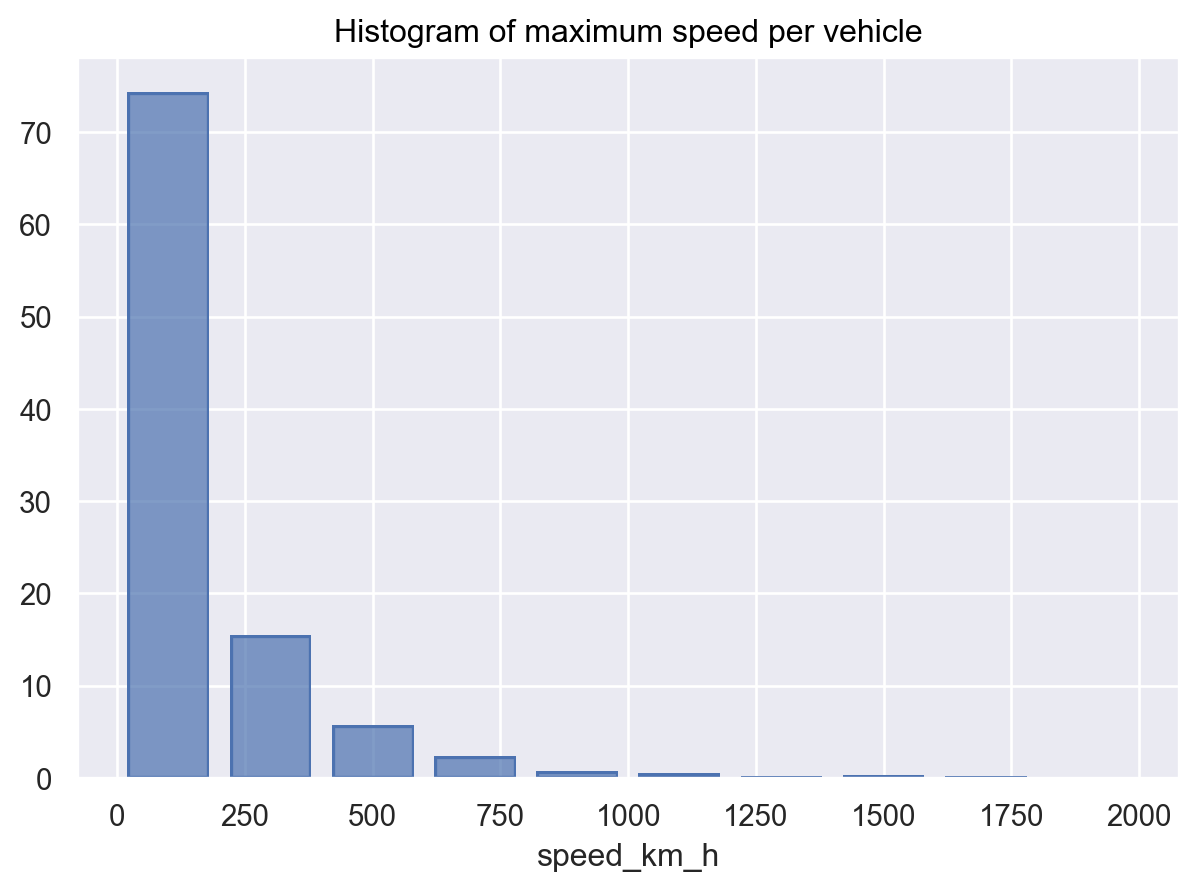

In [66]:
so.Plot(vehicle_speed, "speed_km_h")\
    .add(so.Bar(), so.Hist(stat = "percent", bins = 10, binrange = (0, 2000)))\
    .label(title = "Histogram of maximum speed per vehicle")

While even speeds above 511 km could be deeemed as suspicious, there are some speeds which exceed 10 million km per hour. These must be errors, and should be excluded from analysis.

In [65]:
pd.options.display.float_format = '{:.2f}'.format

vehicle_speed.sort_values(by = "speed_km_h", ascending = False)[0:10]

,speed_km_h
4951,14367957.59
1286,14193107.43
4894,14024389.89
4836,13839252.97
1025,10835285.75
2118,8228178.15
3634,7368598.83
2706,7269942.34
5384,7195170.79
4675,7150336.34


Over 10% of vehicles had speeds of 1000 km/h or larger. Still, let's select this as our "sane threshold", and exclude observations with larger speeds.

In [78]:
len(vehicle_speed[vehicle_speed["speed_km_h"] >= 1000])/len(vehicle_speed)

0.10566247224278312

### Total distance travelled per day

To get the total distance travelled per day, we group by the MMSI, sum to get the total distance, and then sort the dataframe in a descending order.

In [83]:
distance_per_day = df_cleaned\
    .filter(f.col("speed_km_h") < 1000)\
    .groupBy("mmsi")\
    .agg(
        f.sum("distance").alias("total_distance")
    )\
    .orderBy(f.col("total_distance").desc())

### Vessel with the longest distance

Once the dataset has been sorted in a descending order based on the total distance travelled that day, we can find the vessel which has travelled the longest distance.

In [84]:
distance_per_day.show(1, False)

+---------+------------------+
|mmsi     |total_distance    |
+---------+------------------+
|211130000|4077.4400763628864|
+---------+------------------+
only showing top 1 row



### Comparing the top 1 vessel with others

In [89]:
top_vessels = distance_per_day\
    .limit(10)\
    .join(vessel_info, on = ["mmsi"], how = "left")\
    .toPandas()\
    .sort_values(by = "total_distance", ascending = False)\
    .reset_index(drop = True)

We can observe that the top 1 vessel was a law enforcement ship. This is a believable outcome.

In [90]:
top_vessels.loc[0]

mmsi                    211130000
total_distance            4077.44
ship_type         Law enforcement
Name: 0, dtype: object

However, most other vehicles which were in the top 10 by distance travelled were cargo ships:

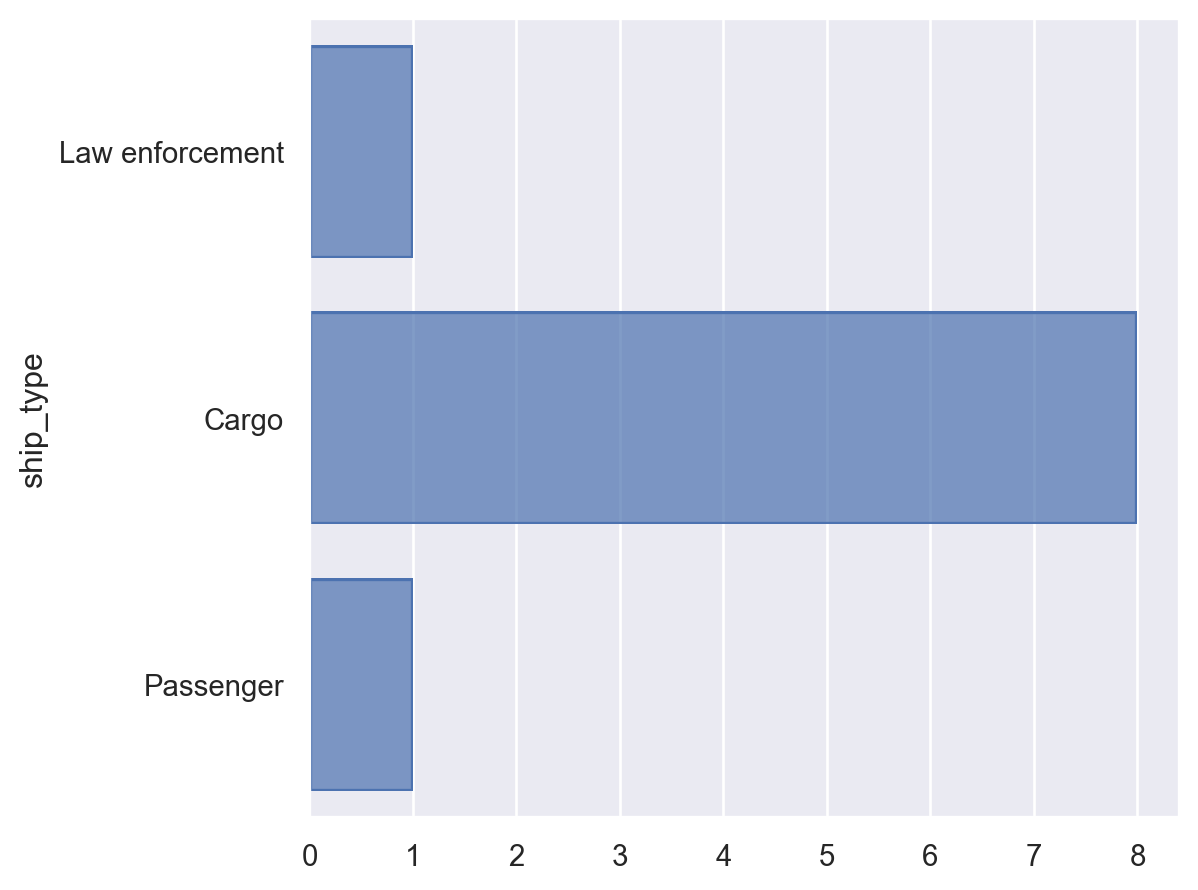

In [91]:
so.Plot(top_vessels, y = "ship_type").add(so.Bar(), so.Count())

In [92]:
first_vs_second_vessel = round(top_vessels["total_distance"][0]/top_vessels["total_distance"][1])

print(f"The first vessel travelled an almost {first_vs_second_vessel} times larger distance than the second one.")

The first vessel travelled an almost 5 times larger distance than the second one.


### Sanity check

It is quite suspicious that the number 1 vehicle had a 5 times longer distance than the number 2 vehicle in terms of distance travelled. Thus, let's look at the longest trips this vehicle took that day.

We can note that the top vehicle was moored most of the time, apart from a single 12 hour trip with an average speed of 338.5 km / h. Looking at typical ship speeds, this is still an unusual outcome.

In [94]:
top_vehicle_data = df_cleaned\
    .filter(f.col("mmsi") == top_vessels["mmsi"][0])\
        .orderBy(f.col("distance").desc())\
        .withColumn("distance_rounded", f.round("distance"))

top_vehicle_data.show(20, False)

+-------------------+--------------+---------+---------+---------+----------------------+----+---+-----+-------+-------+--------+------+---------------+----------+-----+------+------------------------------+-------+-----------+-------------------+----------------+---+---+---+---+-------------+--------------+---------------------+-------------------+--------------------------+--------------------+----------------+
|timestamp          |type_of_mobile|mmsi     |latitude |longitude|navigational_status   |rot |sog|cog  |heading|imo    |callsign|name  |ship_type      |cargo_type|width|length|type_of_position_fixing_device|draught|destination|eta                |data_source_type|a  |b  |c  |d  |prev_latitude|prev_longitude|distance             |prev_timestamp     |hours_since_last_timestamp|speed_km_h          |distance_rounded|
+-------------------+--------------+---------+---------+---------+----------------------+----+---+-----+-------+-------+--------+------+---------------+----------+---

## Final answer

Since the previous result is likely to have been a data error, it is likely that the boat which actually made the longest journey on May 4th was this one:

In [97]:
top_vessels.loc[1]

mmsi              219133000
total_distance       792.75
ship_type             Cargo
Name: 1, dtype: object